# Importação dos dados



In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join


lojas = {
  f"loja{str(i)}": pd.read_csv(join("base-de-dados-challenge-1",f"loja_{str(i)}.csv"))  for i in range(1,5)
}

metricas = { loja: {} for loja in lojas.keys() }

for loja in lojas.values():
    loja["Data da Compra"] = pd.to_datetime(loja["Data da Compra"], format="%d/%m/%Y")

# 0. Analise exploratoria dos dados

In [85]:
print("Colunas e tipos de dados\n\n",lojas["loja1"].dtypes)
print("\n\nDescirção de cada coluna\n\n",lojas["loja1"].describe())

Colunas e tipos de dados

 Produto                           object
Categoria do Produto              object
Preço                            float64
Frete                            float64
Data da Compra            datetime64[ns]
Vendedor                          object
Local da compra                   object
Avaliação da compra                int64
Tipo de pagamento                 object
Quantidade de parcelas             int64
lat                              float64
lon                              float64
dtype: object


Descirção de cada coluna

              Preço        Frete                 Data da Compra  \
count  2359.000000  2359.000000                           2359   
mean    650.491361    34.691805  2021-08-17 12:02:08.189911296   
min      10.070000     0.000000            2020-01-01 00:00:00   
25%      74.345000     4.141783            2020-10-26 00:00:00   
50%     313.750000    16.498835            2021-08-23 00:00:00   
75%     904.130000    48.050074           

# 1. Análise do faturamento


In [86]:
for loja, df in lojas.items():
    faturamento_anual = df.set_index("Data da Compra").resample("YE")["Preço"].sum()
    faturamento_anual.index = faturamento_anual.index.year
    metricas[loja]["Faturamento Anual"] = faturamento_anual
    metricas[loja]["Faturamento Total"] = df["Preço"].sum().item()

# 2. Vendas por Categoria


In [87]:

for loja, df in lojas.items():
    metricas[loja]["vendas por produto"] = df.groupby("Categoria do Produto").agg(vendas = ("Categoria do Produto", "count"))

# 3. Média de Avaliação das Lojas

In [88]:
for loja, df in lojas.items():
    metricas[loja]["Média de Avaliação"] = df["Avaliação da compra"].mean().item()

# 4. Produtos Mais e Menos Vendidos

In [89]:
for loja, df in lojas.items():
    df_n_vendas = df.groupby("Produto").agg(n_vendas = ("Produto", "count"))
    max_vendas = df_n_vendas["n_vendas"].max()
    min_vendas = df_n_vendas["n_vendas"].min()
    
    produtos_extremos = df_n_vendas[
        (df_n_vendas["n_vendas"] == max_vendas) | 
        (df_n_vendas["n_vendas"] == min_vendas)
    ].sort_values("n_vendas")
    
    # Armazenar tanto a tabela completa quanto os produtos extremos
    metricas[loja]["Produtos Mais e Menos Vendidos"] = produtos_extremos


# 5. Frete Médio por Loja


In [90]:
for loja, df in lojas.items():
    metricas[loja]["Frete médio"] = df["Frete"].mean().item()


# Apresentado Metricas

In [91]:
for loja, metrica in metricas.items():
    print(loja)
    for chave, valor in metrica.items():
        print(chave, valor, sep="\n\n")

loja1
Faturamento Anual

Data da Compra
2020    491911.51
2021    482829.91
2022    422086.24
2023    137681.46
Name: Preço, dtype: float64
Faturamento Total

1534509.12
vendas por produto

                       vendas
Categoria do Produto         
brinquedos                324
eletrodomesticos          312
eletronicos               448
esporte e lazer           284
instrumentos musicais     182
livros                    173
moveis                    465
utilidades domesticas     171
Média de Avaliação

3.976685036032217
Produtos Mais e Menos Vendidos

               n_vendas
Produto                
Celular ABXY         33
Headset              33
Guarda roupas        60
Micro-ondas          60
TV Led UHD 4K        60
Frete médio

34.69180491551149
loja2
Faturamento Anual

Data da Compra
2020    427288.25
2021    468288.89
2022    477635.56
2023    115246.36
Name: Preço, dtype: float64
Faturamento Total

1488459.06
vendas por produto

                       vendas
Categoria do Produto 

# Gráficos

## Faturamento anual

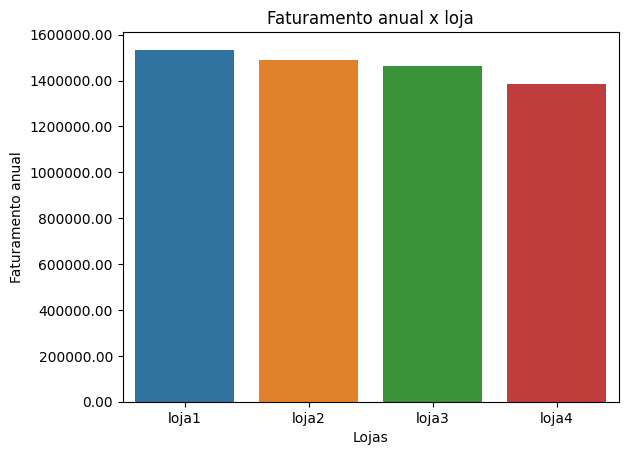

In [92]:
data = [metrica["Faturamento Total"] for metrica in metricas.values()]
keys = metricas.keys()
sns.barplot(x=keys, y=data, hue=keys)
plt.ticklabel_format(axis='y', style='plain')
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.ylabel("Faturamento anual")
plt.xlabel("Lojas")
plt.title("Faturamento anual x loja")
plt.show()
#plt.bar(metricas.keys(), data)

## Vendas por categoria 

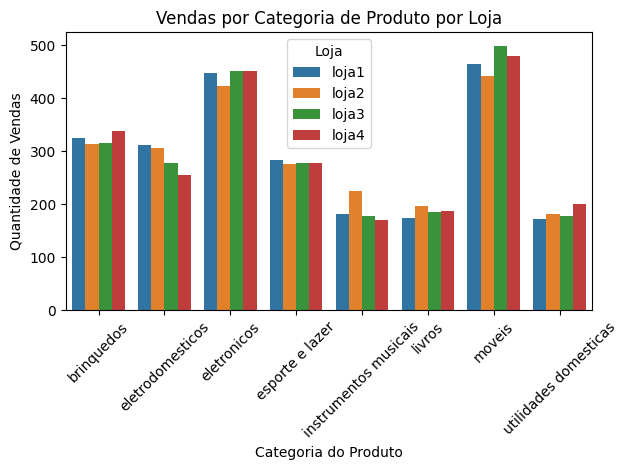

In [93]:
df_vendas = pd.DataFrame()

for loja, metrica in metricas.items():
    vendas_por_categoria = metrica["vendas por produto"].reset_index()
    vendas_por_categoria["loja"] = loja
    df_vendas = pd.concat([df_vendas, vendas_por_categoria])

df_vendas.columns = ['Categoria', 'Vendas', 'Loja']
sns.barplot(df_vendas, x="Categoria", y="Vendas", hue="Loja")
plt.ylabel("Quantidade de Vendas")
plt.xlabel("Categoria do Produto")
plt.title("Vendas por Categoria de Produto por Loja")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## média de avaliação

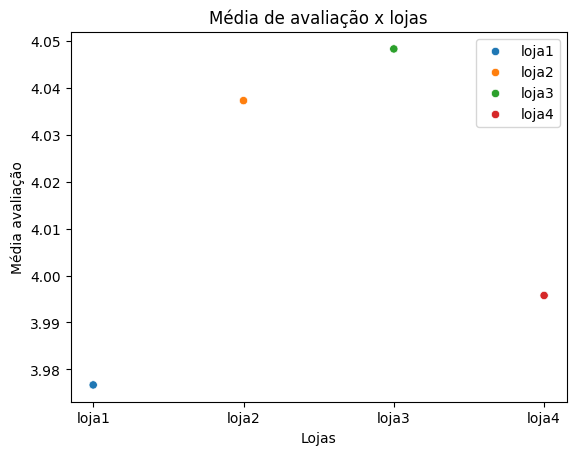

In [94]:
data = [metrica["Média de Avaliação"] for metrica in metricas.values()]
keys = metricas.keys()

sns.scatterplot(x=keys, y=data, hue=keys)
plt.ylabel("Média avaliação")
plt.xlabel("Lojas")
plt.title("Média de avaliação x lojas")
plt.show()

## 4. Produtos Mais e Menos Vendidos

In [95]:
## 4. Produtos Mais e Menos Vendidos

for loja, metrica in metricas.items():
    df = metrica["Produtos Mais e Menos Vendidos"].reset_index()
    df_min = df[df["n_vendas"] == df["n_vendas"].min()]
    df_max = df[df["n_vendas"] == df["n_vendas"].max()]
    display(f"{loja.upper()} - Produtos menos vendido",df_min)
    display(f"{loja.upper()} - Produtos mais vendido",df_max)
    #sns.barplot(data=df, x="Produto", y="n_vendas")
    #plt.show()

#metricas["loja1"]["Produtos mais e menos vendidos"]

'LOJA1 - Produtos menos vendido'

,Produto,n_vendas
0,Celular ABXY,33
1,Headset,33


'LOJA1 - Produtos mais vendido'

,Produto,n_vendas
2,Guarda roupas,60
3,Micro-ondas,60
4,TV Led UHD 4K,60


'LOJA2 - Produtos menos vendido'

,Produto,n_vendas
0,Jogo de tabuleiro,32


'LOJA2 - Produtos mais vendido'

,Produto,n_vendas
1,Iniciando em programação,65


'LOJA3 - Produtos menos vendido'

,Produto,n_vendas
0,Blocos de montar,35


'LOJA3 - Produtos mais vendido'

,Produto,n_vendas
1,Kit banquetas,57


'LOJA4 - Produtos menos vendido'

,Produto,n_vendas
0,Guitarra,33


'LOJA4 - Produtos mais vendido'

,Produto,n_vendas
1,Cama box,62


## 5. Frete Médio por Loja

Text(0.5, 1.0, 'Frete médio x loja')

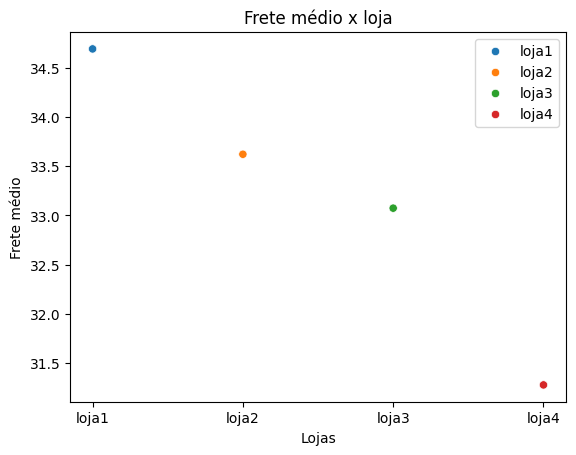

In [96]:
data = [ metrica["Frete médio"] for metrica in metricas.values()]
keys = metricas.keys()

sns.scatterplot(x=keys, y=data,hue=keys)
plt.xlabel("Lojas")
plt.ylabel("Frete médio")
plt.title("Frete médio x loja")